In [246]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
import re
from sklearn.model_selection import train_test_split

In [247]:
data = pd.read_parquet("train_dataset_hackaton2023_train.gzip")
del data['group_name']
data.head()

,customer_id,date_diff_post,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
0,29891,9.0,1,69.99,2022-12-05 12:03:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны
1,29891,9.0,1,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны
2,29891,9.0,1,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны
3,29891,9.0,1,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны
4,29891,9.0,1,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны


In [248]:
#data['dish_name'] = data['dish_name'].str.lower()

In [249]:
#%%time
#data['dish_name'] = data['dish_name'].apply(lambda x: re.sub(r'[^а-яa-z ]', '', x))

In [250]:
customers = data['customer_id'].unique()
customers

array([   29891,    30477,    31426, ..., 46639170, 46654016, 46661804],
      dtype=int64)

In [251]:
train_cust, test_cust = train_test_split(customers, test_size=0.2, random_state=77)

In [252]:
data['isin'] = data['customer_id'].isin(train_cust)

In [253]:
data['dish_name'] = data['dish_name'] + ' '

In [254]:
train_df = data.loc[data['isin']]
test_df = data.loc[~data['isin']]

In [258]:
from datetime import datetime
def get_features(df, plot=False):
    if plot: print('dish_name')
    X = df.groupby(['customer_id'], as_index=False)['dish_name'].sum()
    
    #Количество купленных блюд
    d = df.groupby(['customer_id'], as_index=False)['dish_name'].count()
    d.columns = ['customer_id', 'count_all_dishes']
    X = X.merge(d, on='customer_id', how='inner')
    
    #Количество купленных уникальных блюд
    d = df.groupby(['customer_id'], as_index=False)['dish_name'].nunique()
    d.columns = ['customer_id', 'count_uniq_dishes']
    X = X.merge(d, on='customer_id', how='inner')
    
    #Количество чеков
    d = df.groupby(['customer_id'], as_index=False)['startdatetime'].nunique()
    d.columns = ['customer_id', 'count_bills']
    X = X.merge(d, on='customer_id', how='inner')
    
    #Количество посещённых уникальных мест
    d = df.groupby(['customer_id'], as_index=False)['format_name'].nunique()
    d.columns = ['customer_id', 'count_places']
    X = X.merge(d, on='customer_id', how='inner')
    
    if plot: print('revenue')
    #Минимальная стоимость блюда
    d = df.groupby(['customer_id'], as_index=False)['revenue'].min()
    d.columns = ['customer_id', 'min_revenue']
    X = X.merge(d, on='customer_id', how='inner')
    
    #Максимальная стоимость блюда
    d = df.groupby(['customer_id'], as_index=False)['revenue'].max()
    d.columns = ['customer_id', 'max_revenue']
    X = X.merge(d, on='customer_id', how='inner')
    
    revenue_std = df.groupby('customer_id', as_index=False)['revenue'].std()
    revenue_std.columns = ['customer_id', 'revenue_std']
    X = X.merge(revenue_std, on='customer_id', how='left')
    
    #Средняя стоимость блюда
    d = df.groupby(['customer_id'], as_index=False)['revenue'].mean()
    d.columns = ['customer_id', 'mean_revenue']
    X = X.merge(d, on='customer_id', how='inner')
    
    #Минимальная стоимость чека
    temp = df.groupby(['customer_id', 'startdatetime'], as_index=False)['revenue'].sum()
    d = temp.groupby(['customer_id'], as_index=False)['revenue'].min()
    d.columns = ['customer_id', 'min_bill_revenue']
    X = X.merge(d, on='customer_id', how='inner')
    
    #Максимальная стоимость чека
    d = temp.groupby(['customer_id'], as_index=False)['revenue'].max()
    d.columns = ['customer_id', 'max_bill_revenue']
    X = X.merge(d, on='customer_id', how='inner')
    
    #Средняя стоимость чека
    d = temp.groupby(['customer_id'], as_index=False)['revenue'].mean()
    d.columns = ['customer_id', 'mean_bill_revenue']
    X = X.merge(d, on='customer_id', how='inner')
    del temp
    
    #Общая стоимость чека
    d = df.groupby(['customer_id'], as_index=False)['revenue'].sum()
    d.columns = ['customer_id', 'sum_revenue']
    X = X.merge(d, on='customer_id', how='inner')
    
    if plot: print('mean interval')
    #Средний интервал времени между покупками
    temp = data.sort_values(['customer_id', 'startdatetime'], ascending=True)
    temp['prev_date'] = temp.groupby('customer_id')['startdatetime'].shift(1)
    temp['days_between_purchases'] = (temp['startdatetime'] - temp['prev_date']).dt.days
    
    #Процент количества дней между покупками больших среднего
    mean_days = temp['days_between_purchases'].mean()
    d = temp.copy()
    d['days_more_mean'] = temp['days_between_purchases']>mean_days
    d = d.groupby('customer_id', as_index=False)['days_more_mean'].mean()
    d.columns = ['customer_id', 'percent_days_between_more_avg']
    X = X.merge(d, on='customer_id', how='left')
    
    #Последнее количество дней между покупками
    d = temp.groupby('customer_id', as_index=False)['days_between_purchases'].last()
    d.columns = ['customer_id', 'last_days_between']
    X = X.merge(d, on='customer_id', how='left')
    
    #Среднее количество дней между покупками
    d = temp.groupby('customer_id', as_index=False)['days_between_purchases'].mean()
    d.columns = ['customer_id', 'avg_days_between']
    X = X.merge(d, on='customer_id', how='left')
    
    #Среднее количество дней между покупками
    d = temp.groupby('customer_id', as_index=False)['days_between_purchases'].std()
    d.columns = ['customer_id', 'std_days_between']
    X = X.merge(d, on='customer_id', how='left')
    
    #Максимальное количество дней между покупками
    d = temp.groupby('customer_id', as_index=False)['days_between_purchases'].max()
    d.columns = ['customer_id', 'max_days_between']
    X = X.merge(d, on='customer_id', how='left')
    
    #Минимальная количество дней между покупками
    d = temp.groupby('customer_id', as_index=False)['days_between_purchases'].min()
    d.columns = ['customer_id', 'min_days_between']
    X = X.merge(d, on='customer_id', how='left')
    
    if plot: print('last_activity')
    
    #Последняя активность
    last_purchase = df.groupby('customer_id', as_index=False)['startdatetime'].max()
    last_purchase['last_activity'] = (df['startdatetime'].max()
                                      - last_purchase['startdatetime']).dt.days
    last_purchase.columns = ['customer_id', 'last_purchase_date', 'last_activity']
    X = X.merge(last_purchase[['customer_id', 'last_activity']], on='customer_id', how='left')
    
    print('date_diff')
    d_min = df.groupby(['customer_id'], as_index=False)['startdatetime'].min()
    d_min.columns = ['customer_id', 'min_data']
    d_max = df.groupby(['customer_id'], as_index=False)['startdatetime'].max()
    d_max.columns = ['customer_id', 'max_data']
    d = d_min.merge(d_max, on='customer_id', how='inner')
    d['diff_days'] = (d['max_data']-d['min_data']).dt.days
    d = d.drop(['min_data', 'max_data'], axis=1)
    X = X.merge(d, on='customer_id', how='inner')
    
    s_data = df.drop(['dish_name', 'revenue', 'isin'], axis=1)
    s_data = s_data.drop_duplicates()
    vc_fn = s_data.groupby('customer_id', as_index=False)['format_name'].value_counts()
    uniqs = data['format_name'].unique()
    for uniq in uniqs:
        g = vc_fn.loc[vc_fn['format_name']==uniq]
        g.columns = ['customer_id', 'format_name', 'count_format_name_'+uniq]
        X = X.merge(g.drop(['format_name'], axis=1), on='customer_id', how='left')
    X.fillna(0, inplace=True)
    
    return X

In [271]:
%%time
X_train = get_features(train_df, plot=True)
#del X_train['customer_id']
y_train_bin = train_df.groupby(['customer_id'], as_index=False)['buy_post'].first()
del y_train_bin['customer_id']

dish_name
revenue
mean interval
last_activity
date_diff
CPU times: total: 42.4 s
Wall time: 43.5 s


In [349]:
%%time
X_test = get_features(test_df, plot=True)
#del X_test['customer_id']
y_test_bin = test_df.groupby(['customer_id'], as_index=False)['buy_post'].first()
del y_test_bin['customer_id']

dish_name
revenue
mean interval
last_activity
date_diff
CPU times: total: 20.4 s
Wall time: 21.3 s


In [273]:
%%time
X = get_features(data, plot=True)
#del X['customer_id']
y_bin = data.groupby(['customer_id'], as_index=False)['buy_post'].first()
del y_bin['customer_id']

dish_name
revenue
mean interval
last_activity
date_diff
CPU times: total: 50.2 s
Wall time: 50.8 s


In [233]:
X.columns[:-9]

Index(['dish_name', 'count_all_dishes', 'count_uniq_dishes', 'count_bills',
       'count_places', 'min_revenue', 'max_revenue', 'revenue_std',
       'mean_revenue', 'min_bill_revenue', 'max_bill_revenue',
       'mean_bill_revenue', 'sum_revenue', 'percent_days_between_more_avg',
       'last_days_between', 'avg_days_between', 'std_days_between',
       'max_days_between', 'min_days_between', 'last_activity', 'diff_days'],
      dtype='object')

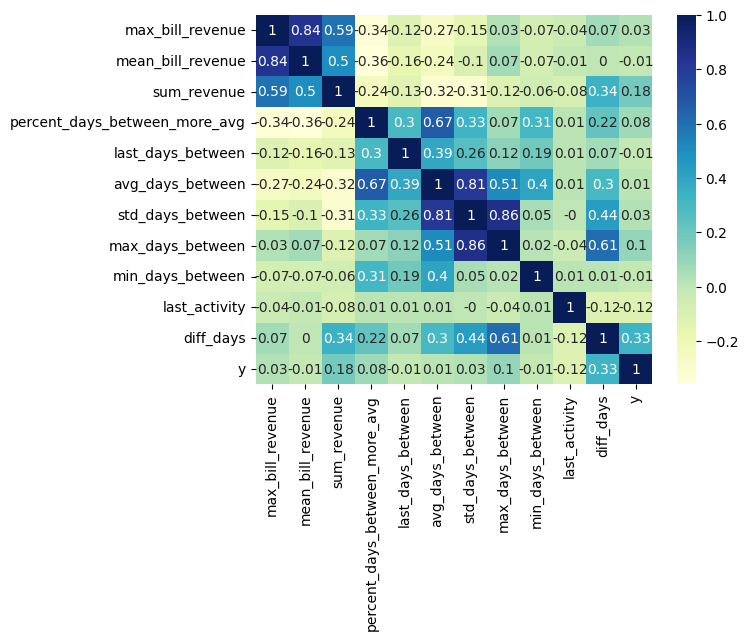

In [208]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
temp = X[X.columns[:-9]]
temp = temp[temp.columns[int(len(temp.columns)/2):int(len(temp.columns))]]
temp['y'] = y
dataplot = sns.heatmap(np.round(temp.corr(), 2), cmap="YlGnBu", annot=True)
plt.show()

In [263]:
model = CatBoostClassifier(random_state=77, iterations=500,
                           text_features=['dish_name'],
                           eval_metric='F1',
                           auto_class_weights='Balanced')
model.fit(X_train.drop(['customer_id'], axis=1), y_train_bin, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.251222
0:	learn: 0.6312187	total: 467ms	remaining: 3m 53s
1:	learn: 0.6409905	total: 876ms	remaining: 3m 38s
2:	learn: 0.6492208	total: 1.29s	remaining: 3m 33s
3:	learn: 0.6510517	total: 1.73s	remaining: 3m 35s
4:	learn: 0.6520382	total: 2.12s	remaining: 3m 29s
5:	learn: 0.6506169	total: 2.56s	remaining: 3m 31s
6:	learn: 0.6502664	total: 2.98s	remaining: 3m 29s
7:	learn: 0.6514284	total: 3.35s	remaining: 3m 25s
8:	learn: 0.6534397	total: 3.75s	remaining: 3m 24s
9:	learn: 0.6538530	total: 4.13s	remaining: 3m 22s
10:	learn: 0.6533394	total: 4.47s	remaining: 3m 18s
11:	learn: 0.6540242	total: 4.84s	remaining: 3m 16s
12:	learn: 0.6544696	total: 5.24s	remaining: 3m 16s
13:	learn: 0.6546796	total: 5.51s	remaining: 3m 11s
14:	learn: 0.6546369	total: 5.84s	remaining: 3m 8s
15:	learn: 0.6547229	total: 6.2s	remaining: 3m 7s
16:	learn: 0.6552218	total: 6.62s	remaining: 3m 8s
17:	learn: 0.6553713	total: 6.93s	remaining: 3m 5s
18:	learn: 0.6555545	total: 7.34s	remaining: 3m 5

158:	learn: 0.6727308	total: 54.5s	remaining: 1m 56s
159:	learn: 0.6727594	total: 54.8s	remaining: 1m 56s
160:	learn: 0.6728597	total: 55.2s	remaining: 1m 56s
161:	learn: 0.6731179	total: 55.6s	remaining: 1m 56s
162:	learn: 0.6733221	total: 55.9s	remaining: 1m 55s
163:	learn: 0.6733700	total: 56.2s	remaining: 1m 55s
164:	learn: 0.6732244	total: 56.5s	remaining: 1m 54s
165:	learn: 0.6733897	total: 56.9s	remaining: 1m 54s
166:	learn: 0.6733850	total: 57.2s	remaining: 1m 54s
167:	learn: 0.6735450	total: 57.6s	remaining: 1m 53s
168:	learn: 0.6736698	total: 58s	remaining: 1m 53s
169:	learn: 0.6737028	total: 58.3s	remaining: 1m 53s
170:	learn: 0.6737822	total: 58.7s	remaining: 1m 52s
171:	learn: 0.6738407	total: 59s	remaining: 1m 52s
172:	learn: 0.6739592	total: 59.4s	remaining: 1m 52s
173:	learn: 0.6739263	total: 59.8s	remaining: 1m 52s
174:	learn: 0.6739580	total: 1m	remaining: 1m 51s
175:	learn: 0.6739895	total: 1m	remaining: 1m 51s
176:	learn: 0.6741098	total: 1m	remaining: 1m 50s
177:	l

312:	learn: 0.6844564	total: 1m 46s	remaining: 1m 3s
313:	learn: 0.6845270	total: 1m 46s	remaining: 1m 3s
314:	learn: 0.6846048	total: 1m 46s	remaining: 1m 2s
315:	learn: 0.6846814	total: 1m 47s	remaining: 1m 2s
316:	learn: 0.6847476	total: 1m 47s	remaining: 1m 2s
317:	learn: 0.6847883	total: 1m 47s	remaining: 1m 1s
318:	learn: 0.6848356	total: 1m 47s	remaining: 1m 1s
319:	learn: 0.6849034	total: 1m 48s	remaining: 1m
320:	learn: 0.6851143	total: 1m 48s	remaining: 1m
321:	learn: 0.6851471	total: 1m 48s	remaining: 1m
322:	learn: 0.6852684	total: 1m 49s	remaining: 59.8s
323:	learn: 0.6854240	total: 1m 49s	remaining: 59.5s
324:	learn: 0.6854158	total: 1m 49s	remaining: 59.1s
325:	learn: 0.6855164	total: 1m 50s	remaining: 58.7s
326:	learn: 0.6855500	total: 1m 50s	remaining: 58.4s
327:	learn: 0.6855827	total: 1m 50s	remaining: 58s
328:	learn: 0.6857423	total: 1m 50s	remaining: 57.7s
329:	learn: 0.6857375	total: 1m 51s	remaining: 57.3s
330:	learn: 0.6858101	total: 1m 51s	remaining: 57s
331:	l

468:	learn: 0.6946526	total: 2m 38s	remaining: 10.5s
469:	learn: 0.6947643	total: 2m 38s	remaining: 10.1s
470:	learn: 0.6947932	total: 2m 38s	remaining: 9.79s
471:	learn: 0.6949465	total: 2m 39s	remaining: 9.45s
472:	learn: 0.6950234	total: 2m 39s	remaining: 9.11s
473:	learn: 0.6950975	total: 2m 39s	remaining: 8.77s
474:	learn: 0.6952311	total: 2m 40s	remaining: 8.44s
475:	learn: 0.6952229	total: 2m 40s	remaining: 8.1s
476:	learn: 0.6952751	total: 2m 41s	remaining: 7.76s
477:	learn: 0.6954197	total: 2m 41s	remaining: 7.43s
478:	learn: 0.6955048	total: 2m 41s	remaining: 7.09s
479:	learn: 0.6955496	total: 2m 42s	remaining: 6.76s
480:	learn: 0.6956342	total: 2m 42s	remaining: 6.42s
481:	learn: 0.6957040	total: 2m 43s	remaining: 6.09s
482:	learn: 0.6957643	total: 2m 43s	remaining: 5.75s
483:	learn: 0.6958217	total: 2m 43s	remaining: 5.42s
484:	learn: 0.6958756	total: 2m 44s	remaining: 5.08s
485:	learn: 0.6959001	total: 2m 44s	remaining: 4.74s
486:	learn: 0.6959324	total: 2m 45s	remaining: 

In [350]:
from sklearn.metrics import f1_score
pred = model.predict(X_test.drop(['customer_id'], axis=1))
f1_score(y_test_bin, pred)

C:\Users\Владислав\AppData\Roaming\Python\Python310\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0.7323578264652376

In [351]:
pred_proba = model.predict_proba(X_test.drop(['customer_id'], axis=1))[:,1]

C:\Users\Владислав\AppData\Roaming\Python\Python310\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [352]:
y_test_bin.shape

(100000, 1)

In [353]:
pred_proba.shape

(100000,)

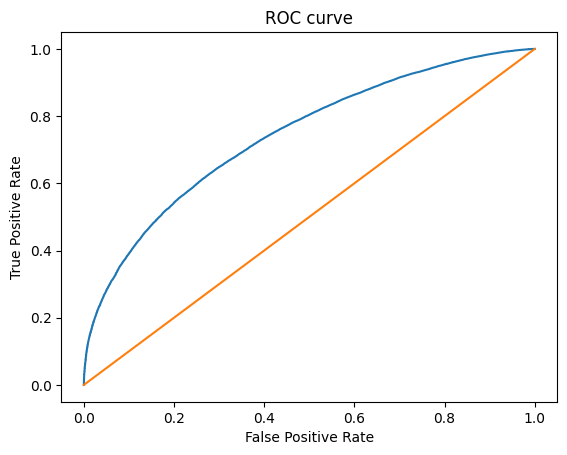

In [355]:
from sklearn import metrics
ns_probs = [0 for _ in range(len(y_test_bin))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test_bin, ns_probs)
plt.title('ROC curve')

fpr, tpr, _ = metrics.roc_curve(y_test_bin, pred_proba)
auc = round(metrics.roc_auc_score(y_test_bin, pred_proba),4)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(ns_fpr,ns_tpr)
plt.show()

In [265]:
weights = pd.DataFrame({'column': X_train.columns,
                        'weight': model.feature_importances_})
weights.sort_values(by='weight', ascending=False).head(30)

,column,weight
0,dish_name,40.189526
20,diff_days,13.869320
19,last_activity,13.252453
3,count_bills,7.625619
17,max_days_between,2.750448
16,std_days_between,2.551464
15,avg_days_between,2.477314
13,percent_days_between_more_avg,2.363872
1,count_all_dishes,2.321475
9,min_bill_revenue,1.677762


In [290]:
X_train_reg = X_train.copy()
X_train_reg = X_train_reg.merge(train_df.groupby(['customer_id'], as_index=False)['date_diff_post'].first(),
                                on = 'customer_id', how='inner')
X_train_reg.dropna(inplace=True)
y_train_reg = X_train_reg['date_diff_post']
del X_train_reg['date_diff_post']
#del X_train_reg['last_activity']

X_test_reg = X_test.copy()
X_test_reg = X_test_reg.merge(test_df.groupby(['customer_id'], as_index=False)['date_diff_post'].first(),
                                on = 'customer_id', how='inner')
X_test_reg.dropna(inplace=True)
y_test_reg = X_test_reg['date_diff_post']
del X_test_reg['date_diff_post']
#del X_test_reg['last_activity']

X_reg = X.copy()
X_reg = X_reg.merge(data.groupby(['customer_id'], as_index=False)['date_diff_post'].first(),
                                on = 'customer_id', how='inner')
X_reg.dropna(inplace=True)
y_reg = X_reg['date_diff_post']
del X_reg['date_diff_post']
#del X_reg['last_activity']

In [291]:
model_reg = CatBoostRegressor(random_state=77, iterations=500, text_features=['dish_name'])
model_reg.fit(X_train_reg.drop(['customer_id'], axis=1), y_train_reg, plot=True)

C:\Users\Владислав\AppData\Roaming\Python\Python310\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.175929
0:	learn: 15.1138924	total: 188ms	remaining: 1m 33s
1:	learn: 14.7353017	total: 391ms	remaining: 1m 37s
2:	learn: 14.4512612	total: 613ms	remaining: 1m 41s
3:	learn: 14.2526927	total: 834ms	remaining: 1m 43s
4:	learn: 14.1101216	total: 1.05s	remaining: 1m 44s
5:	learn: 14.0185986	total: 1.24s	remaining: 1m 41s
6:	learn: 13.9267802	total: 1.41s	remaining: 1m 39s
7:	learn: 13.8631678	total: 1.59s	remaining: 1m 37s
8:	learn: 13.8092338	total: 1.77s	remaining: 1m 36s
9:	learn: 13.7691017	total: 1.96s	remaining: 1m 36s
10:	learn: 13.7311187	total: 2.16s	remaining: 1m 35s
11:	learn: 13.7042827	total: 2.3s	remaining: 1m 33s
12:	learn: 13.6698303	total: 2.52s	remaining: 1m 34s
13:	learn: 13.6551223	total: 2.71s	remaining: 1m 33s
14:	learn: 13.6430692	total: 2.91s	remaining: 1m 34s
15:	learn: 13.6221075	total: 3.09s	remaining: 1m 33s
16:	learn: 13.5969068	total: 3.24s	remaining: 1m 32s
17:	learn: 13.5785426	total: 3.39s	remaining: 1m 30s
18:	learn: 13.5641156	total

154:	learn: 12.8827885	total: 31.4s	remaining: 1m 9s
155:	learn: 12.8790917	total: 31.6s	remaining: 1m 9s
156:	learn: 12.8784126	total: 31.8s	remaining: 1m 9s
157:	learn: 12.8775174	total: 31.9s	remaining: 1m 9s
158:	learn: 12.8765588	total: 32.1s	remaining: 1m 8s
159:	learn: 12.8737731	total: 32.3s	remaining: 1m 8s
160:	learn: 12.8728171	total: 32.5s	remaining: 1m 8s
161:	learn: 12.8720341	total: 32.7s	remaining: 1m 8s
162:	learn: 12.8710305	total: 32.9s	remaining: 1m 8s
163:	learn: 12.8699548	total: 33.1s	remaining: 1m 7s
164:	learn: 12.8687288	total: 33.2s	remaining: 1m 7s
165:	learn: 12.8677858	total: 33.4s	remaining: 1m 7s
166:	learn: 12.8639826	total: 33.6s	remaining: 1m 6s
167:	learn: 12.8633898	total: 33.8s	remaining: 1m 6s
168:	learn: 12.8626160	total: 33.9s	remaining: 1m 6s
169:	learn: 12.8596394	total: 34.1s	remaining: 1m 6s
170:	learn: 12.8578612	total: 34.4s	remaining: 1m 6s
171:	learn: 12.8570206	total: 34.5s	remaining: 1m 5s
172:	learn: 12.8561069	total: 34.7s	remaining:

311:	learn: 12.7416057	total: 1m	remaining: 36.6s
312:	learn: 12.7411231	total: 1m	remaining: 36.4s
313:	learn: 12.7406189	total: 1m 1s	remaining: 36.2s
314:	learn: 12.7400481	total: 1m 1s	remaining: 36s
315:	learn: 12.7394933	total: 1m 1s	remaining: 35.8s
316:	learn: 12.7385661	total: 1m 1s	remaining: 35.7s
317:	learn: 12.7380822	total: 1m 2s	remaining: 35.5s
318:	learn: 12.7369562	total: 1m 2s	remaining: 35.3s
319:	learn: 12.7364484	total: 1m 2s	remaining: 35.1s
320:	learn: 12.7360823	total: 1m 2s	remaining: 35s
321:	learn: 12.7353651	total: 1m 2s	remaining: 34.8s
322:	learn: 12.7351092	total: 1m 3s	remaining: 34.5s
323:	learn: 12.7343872	total: 1m 3s	remaining: 34.4s
324:	learn: 12.7339748	total: 1m 3s	remaining: 34.2s
325:	learn: 12.7331602	total: 1m 3s	remaining: 34s
326:	learn: 12.7319091	total: 1m 3s	remaining: 33.8s
327:	learn: 12.7314546	total: 1m 3s	remaining: 33.5s
328:	learn: 12.7307742	total: 1m 4s	remaining: 33.3s
329:	learn: 12.7301232	total: 1m 4s	remaining: 33.1s
330:	

465:	learn: 12.6495880	total: 1m 27s	remaining: 6.39s
466:	learn: 12.6491066	total: 1m 27s	remaining: 6.2s
467:	learn: 12.6487202	total: 1m 27s	remaining: 6.01s
468:	learn: 12.6481864	total: 1m 28s	remaining: 5.82s
469:	learn: 12.6474852	total: 1m 28s	remaining: 5.64s
470:	learn: 12.6468861	total: 1m 28s	remaining: 5.45s
471:	learn: 12.6465966	total: 1m 28s	remaining: 5.26s
472:	learn: 12.6460513	total: 1m 28s	remaining: 5.07s
473:	learn: 12.6452508	total: 1m 29s	remaining: 4.89s
474:	learn: 12.6446671	total: 1m 29s	remaining: 4.7s
475:	learn: 12.6428121	total: 1m 29s	remaining: 4.51s
476:	learn: 12.6419769	total: 1m 29s	remaining: 4.33s
477:	learn: 12.6415941	total: 1m 29s	remaining: 4.13s
478:	learn: 12.6409991	total: 1m 29s	remaining: 3.94s
479:	learn: 12.6399952	total: 1m 30s	remaining: 3.76s
480:	learn: 12.6394629	total: 1m 30s	remaining: 3.57s
481:	learn: 12.6387730	total: 1m 30s	remaining: 3.38s
482:	learn: 12.6373787	total: 1m 30s	remaining: 3.19s
483:	learn: 12.6368009	total: 

In [292]:
weights = pd.DataFrame({'column': X_train_reg.drop(['customer_id'], axis=1).columns,
                        'weight': model_reg.feature_importances_})
weights.sort_values(by='weight', ascending=False).head(30)

,column,weight
19,last_activity,55.222890
20,diff_days,17.227951
3,count_bills,11.931879
0,dish_name,8.097588
16,std_days_between,1.018785
9,min_bill_revenue,0.942100
13,percent_days_between_more_avg,0.805744
17,max_days_between,0.795960
11,mean_bill_revenue,0.430619
5,min_revenue,0.379106


In [293]:
from sklearn.metrics import mean_squared_error, r2_score
pred = model_reg.predict(X_test_reg.drop(['customer_id'], axis=1))
mean_squared_error(pred, y_test_reg, squared=False)

C:\Users\Владислав\AppData\Roaming\Python\Python310\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


12.858029600879721

In [298]:
final_model = CatBoostClassifier(random_state=77, iterations=1500,
                           text_features=['dish_name'],
                           eval_metric='F1',
                           auto_class_weights='Balanced')
final_model.fit(X.drop(['customer_id'], axis=1), y, plot=True)

C:\Users\Владислав\AppData\Roaming\Python\Python310\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.100906
0:	learn: 0.6621535	total: 355ms	remaining: 8m 51s
1:	learn: 0.6519994	total: 719ms	remaining: 8m 58s
2:	learn: 0.6595092	total: 1.12s	remaining: 9m 18s
3:	learn: 0.6515396	total: 1.54s	remaining: 9m 35s
4:	learn: 0.6480581	total: 1.98s	remaining: 9m 53s
5:	learn: 0.6468106	total: 2.4s	remaining: 9m 58s
6:	learn: 0.6475520	total: 2.91s	remaining: 10m 19s
7:	learn: 0.6477437	total: 3.34s	remaining: 10m 22s
8:	learn: 0.6457086	total: 3.94s	remaining: 10m 52s
9:	learn: 0.6474912	total: 4.36s	remaining: 10m 49s
10:	learn: 0.6476963	total: 4.82s	remaining: 10m 52s
11:	learn: 0.6473819	total: 5.15s	remaining: 10m 38s
12:	learn: 0.6478168	total: 5.52s	remaining: 10m 31s
13:	learn: 0.6485175	total: 5.84s	remaining: 10m 19s
14:	learn: 0.6489191	total: 6.21s	remaining: 10m 14s
15:	learn: 0.6496919	total: 6.58s	remaining: 10m 10s
16:	learn: 0.6494166	total: 6.9s	remaining: 10m 1s
17:	learn: 0.6500415	total: 7.23s	remaining: 9m 55s
18:	learn: 0.6512656	total: 7.59s	re

157:	learn: 0.6610724	total: 55.6s	remaining: 7m 52s
158:	learn: 0.6611849	total: 56.2s	remaining: 7m 53s
159:	learn: 0.6613012	total: 56.6s	remaining: 7m 54s
160:	learn: 0.6613909	total: 57s	remaining: 7m 53s
161:	learn: 0.6615745	total: 57.3s	remaining: 7m 53s
162:	learn: 0.6616323	total: 57.6s	remaining: 7m 52s
163:	learn: 0.6616710	total: 57.9s	remaining: 7m 51s
164:	learn: 0.6616591	total: 58.2s	remaining: 7m 50s
165:	learn: 0.6617726	total: 58.5s	remaining: 7m 49s
166:	learn: 0.6617079	total: 58.8s	remaining: 7m 49s
167:	learn: 0.6617893	total: 59.1s	remaining: 7m 48s
168:	learn: 0.6618257	total: 59.5s	remaining: 7m 48s
169:	learn: 0.6619004	total: 59.8s	remaining: 7m 47s
170:	learn: 0.6620897	total: 1m	remaining: 7m 47s
171:	learn: 0.6621070	total: 1m	remaining: 7m 47s
172:	learn: 0.6622642	total: 1m	remaining: 7m 46s
173:	learn: 0.6622308	total: 1m 1s	remaining: 7m 48s
174:	learn: 0.6622676	total: 1m 1s	remaining: 7m 47s
175:	learn: 0.6623154	total: 1m 2s	remaining: 7m 46s
176:

311:	learn: 0.6673866	total: 1m 45s	remaining: 6m 42s
312:	learn: 0.6674256	total: 1m 46s	remaining: 6m 42s
313:	learn: 0.6674863	total: 1m 46s	remaining: 6m 41s
314:	learn: 0.6674836	total: 1m 46s	remaining: 6m 41s
315:	learn: 0.6675316	total: 1m 46s	remaining: 6m 40s
316:	learn: 0.6675355	total: 1m 47s	remaining: 6m 40s
317:	learn: 0.6675151	total: 1m 47s	remaining: 6m 40s
318:	learn: 0.6675953	total: 1m 48s	remaining: 6m 40s
319:	learn: 0.6676256	total: 1m 48s	remaining: 6m 40s
320:	learn: 0.6676644	total: 1m 48s	remaining: 6m 39s
321:	learn: 0.6676906	total: 1m 49s	remaining: 6m 39s
322:	learn: 0.6677008	total: 1m 49s	remaining: 6m 39s
323:	learn: 0.6676928	total: 1m 49s	remaining: 6m 38s
324:	learn: 0.6677570	total: 1m 50s	remaining: 6m 38s
325:	learn: 0.6677861	total: 1m 50s	remaining: 6m 37s
326:	learn: 0.6677662	total: 1m 50s	remaining: 6m 36s
327:	learn: 0.6678230	total: 1m 50s	remaining: 6m 36s
328:	learn: 0.6678650	total: 1m 51s	remaining: 6m 35s
329:	learn: 0.6678332	total:

465:	learn: 0.6723145	total: 2m 33s	remaining: 5m 41s
466:	learn: 0.6722950	total: 2m 34s	remaining: 5m 40s
467:	learn: 0.6722981	total: 2m 34s	remaining: 5m 40s
468:	learn: 0.6723540	total: 2m 34s	remaining: 5m 40s
469:	learn: 0.6724091	total: 2m 35s	remaining: 5m 39s
470:	learn: 0.6724273	total: 2m 35s	remaining: 5m 39s
471:	learn: 0.6724688	total: 2m 35s	remaining: 5m 39s
472:	learn: 0.6725161	total: 2m 36s	remaining: 5m 39s
473:	learn: 0.6725140	total: 2m 36s	remaining: 5m 38s
474:	learn: 0.6724975	total: 2m 36s	remaining: 5m 38s
475:	learn: 0.6724873	total: 2m 37s	remaining: 5m 37s
476:	learn: 0.6725210	total: 2m 37s	remaining: 5m 37s
477:	learn: 0.6725896	total: 2m 37s	remaining: 5m 36s
478:	learn: 0.6726158	total: 2m 37s	remaining: 5m 36s
479:	learn: 0.6726517	total: 2m 38s	remaining: 5m 36s
480:	learn: 0.6726622	total: 2m 38s	remaining: 5m 35s
481:	learn: 0.6726475	total: 2m 38s	remaining: 5m 35s
482:	learn: 0.6726450	total: 2m 39s	remaining: 5m 35s
483:	learn: 0.6726560	total:

618:	learn: 0.6761980	total: 3m 37s	remaining: 5m 8s
619:	learn: 0.6762286	total: 3m 37s	remaining: 5m 8s
620:	learn: 0.6762556	total: 3m 37s	remaining: 5m 8s
621:	learn: 0.6762782	total: 3m 37s	remaining: 5m 7s
622:	learn: 0.6763125	total: 3m 38s	remaining: 5m 7s
623:	learn: 0.6762753	total: 3m 38s	remaining: 5m 6s
624:	learn: 0.6763106	total: 3m 38s	remaining: 5m 6s
625:	learn: 0.6763498	total: 3m 39s	remaining: 5m 5s
626:	learn: 0.6763468	total: 3m 39s	remaining: 5m 5s
627:	learn: 0.6763581	total: 3m 39s	remaining: 5m 4s
628:	learn: 0.6764327	total: 3m 39s	remaining: 5m 4s
629:	learn: 0.6764398	total: 3m 40s	remaining: 5m 4s
630:	learn: 0.6764738	total: 3m 40s	remaining: 5m 3s
631:	learn: 0.6765236	total: 3m 41s	remaining: 5m 3s
632:	learn: 0.6765703	total: 3m 41s	remaining: 5m 3s
633:	learn: 0.6765850	total: 3m 41s	remaining: 5m 2s
634:	learn: 0.6765976	total: 3m 42s	remaining: 5m 2s
635:	learn: 0.6766064	total: 3m 42s	remaining: 5m 2s
636:	learn: 0.6766265	total: 3m 42s	remaining:

771:	learn: 0.6799788	total: 4m 27s	remaining: 4m 11s
772:	learn: 0.6800424	total: 4m 27s	remaining: 4m 11s
773:	learn: 0.6800359	total: 4m 27s	remaining: 4m 11s
774:	learn: 0.6800282	total: 4m 28s	remaining: 4m 11s
775:	learn: 0.6800514	total: 4m 28s	remaining: 4m 10s
776:	learn: 0.6800938	total: 4m 29s	remaining: 4m 10s
777:	learn: 0.6801527	total: 4m 29s	remaining: 4m 10s
778:	learn: 0.6801488	total: 4m 29s	remaining: 4m 9s
779:	learn: 0.6802106	total: 4m 30s	remaining: 4m 9s
780:	learn: 0.6802378	total: 4m 30s	remaining: 4m 9s
781:	learn: 0.6802812	total: 4m 30s	remaining: 4m 8s
782:	learn: 0.6802664	total: 4m 31s	remaining: 4m 8s
783:	learn: 0.6803402	total: 4m 31s	remaining: 4m 7s
784:	learn: 0.6803459	total: 4m 31s	remaining: 4m 7s
785:	learn: 0.6803648	total: 4m 32s	remaining: 4m 7s
786:	learn: 0.6804719	total: 4m 32s	remaining: 4m 6s
787:	learn: 0.6804635	total: 4m 32s	remaining: 4m 6s
788:	learn: 0.6804734	total: 4m 33s	remaining: 4m 6s
789:	learn: 0.6805184	total: 4m 33s	rem

925:	learn: 0.6835578	total: 5m 17s	remaining: 3m 16s
926:	learn: 0.6836133	total: 5m 17s	remaining: 3m 16s
927:	learn: 0.6836836	total: 5m 17s	remaining: 3m 15s
928:	learn: 0.6836886	total: 5m 18s	remaining: 3m 15s
929:	learn: 0.6837833	total: 5m 18s	remaining: 3m 15s
930:	learn: 0.6838478	total: 5m 18s	remaining: 3m 14s
931:	learn: 0.6838275	total: 5m 19s	remaining: 3m 14s
932:	learn: 0.6838475	total: 5m 19s	remaining: 3m 14s
933:	learn: 0.6838762	total: 5m 20s	remaining: 3m 13s
934:	learn: 0.6838761	total: 5m 20s	remaining: 3m 13s
935:	learn: 0.6839125	total: 5m 20s	remaining: 3m 13s
936:	learn: 0.6839528	total: 5m 21s	remaining: 3m 12s
937:	learn: 0.6839790	total: 5m 21s	remaining: 3m 12s
938:	learn: 0.6839859	total: 5m 21s	remaining: 3m 12s
939:	learn: 0.6839655	total: 5m 22s	remaining: 3m 11s
940:	learn: 0.6840065	total: 5m 22s	remaining: 3m 11s
941:	learn: 0.6840527	total: 5m 22s	remaining: 3m 11s
942:	learn: 0.6840655	total: 5m 22s	remaining: 3m 10s
943:	learn: 0.6840828	total:

1077:	learn: 0.6868166	total: 6m 6s	remaining: 2m 23s
1078:	learn: 0.6868633	total: 6m 7s	remaining: 2m 23s
1079:	learn: 0.6868792	total: 6m 7s	remaining: 2m 22s
1080:	learn: 0.6869061	total: 6m 8s	remaining: 2m 22s
1081:	learn: 0.6869253	total: 6m 8s	remaining: 2m 22s
1082:	learn: 0.6869515	total: 6m 8s	remaining: 2m 21s
1083:	learn: 0.6869592	total: 6m 8s	remaining: 2m 21s
1084:	learn: 0.6869944	total: 6m 9s	remaining: 2m 21s
1085:	learn: 0.6870135	total: 6m 9s	remaining: 2m 20s
1086:	learn: 0.6870219	total: 6m 10s	remaining: 2m 20s
1087:	learn: 0.6870212	total: 6m 10s	remaining: 2m 20s
1088:	learn: 0.6870385	total: 6m 10s	remaining: 2m 19s
1089:	learn: 0.6870756	total: 6m 11s	remaining: 2m 19s
1090:	learn: 0.6871236	total: 6m 11s	remaining: 2m 19s
1091:	learn: 0.6871542	total: 6m 11s	remaining: 2m 18s
1092:	learn: 0.6871645	total: 6m 11s	remaining: 2m 18s
1093:	learn: 0.6872118	total: 6m 12s	remaining: 2m 18s
1094:	learn: 0.6872994	total: 6m 12s	remaining: 2m 17s
1095:	learn: 0.6872

1227:	learn: 0.6902126	total: 7m	remaining: 1m 33s
1228:	learn: 0.6901659	total: 7m 1s	remaining: 1m 32s
1229:	learn: 0.6901680	total: 7m 1s	remaining: 1m 32s
1230:	learn: 0.6902205	total: 7m 1s	remaining: 1m 32s
1231:	learn: 0.6903151	total: 7m 2s	remaining: 1m 31s
1232:	learn: 0.6903380	total: 7m 2s	remaining: 1m 31s
1233:	learn: 0.6904212	total: 7m 2s	remaining: 1m 31s
1234:	learn: 0.6904327	total: 7m 3s	remaining: 1m 30s
1235:	learn: 0.6904175	total: 7m 3s	remaining: 1m 30s
1236:	learn: 0.6904546	total: 7m 4s	remaining: 1m 30s
1237:	learn: 0.6904456	total: 7m 4s	remaining: 1m 29s
1238:	learn: 0.6904194	total: 7m 4s	remaining: 1m 29s
1239:	learn: 0.6904726	total: 7m 5s	remaining: 1m 29s
1240:	learn: 0.6904961	total: 7m 5s	remaining: 1m 28s
1241:	learn: 0.6904966	total: 7m 6s	remaining: 1m 28s
1242:	learn: 0.6905208	total: 7m 6s	remaining: 1m 28s
1243:	learn: 0.6905354	total: 7m 6s	remaining: 1m 27s
1244:	learn: 0.6905616	total: 7m 7s	remaining: 1m 27s
1245:	learn: 0.6906230	total: 7

1379:	learn: 0.6934570	total: 7m 51s	remaining: 41s
1380:	learn: 0.6935112	total: 7m 51s	remaining: 40.6s
1381:	learn: 0.6935061	total: 7m 52s	remaining: 40.3s
1382:	learn: 0.6935433	total: 7m 52s	remaining: 40s
1383:	learn: 0.6935138	total: 7m 52s	remaining: 39.6s
1384:	learn: 0.6935525	total: 7m 53s	remaining: 39.3s
1385:	learn: 0.6936350	total: 7m 53s	remaining: 39s
1386:	learn: 0.6936537	total: 7m 54s	remaining: 38.6s
1387:	learn: 0.6936844	total: 7m 54s	remaining: 38.3s
1388:	learn: 0.6937218	total: 7m 54s	remaining: 37.9s
1389:	learn: 0.6937684	total: 7m 55s	remaining: 37.6s
1390:	learn: 0.6937854	total: 7m 55s	remaining: 37.2s
1391:	learn: 0.6938461	total: 7m 55s	remaining: 36.9s
1392:	learn: 0.6938420	total: 7m 56s	remaining: 36.6s
1393:	learn: 0.6938629	total: 7m 56s	remaining: 36.2s
1394:	learn: 0.6939369	total: 7m 56s	remaining: 35.9s
1395:	learn: 0.6939635	total: 7m 57s	remaining: 35.5s
1396:	learn: 0.6939866	total: 7m 57s	remaining: 35.2s
1397:	learn: 0.6940068	total: 7m 5

In [299]:
final_model.save_model('bin_model', format="cbm")

In [302]:
weights_bin = pd.DataFrame({'column': X.drop(['customer_id'], axis=1).columns,
                        'weight': final_model.feature_importances_})
weights_bin.sort_values(by='weight', ascending=False).head(30)

,column,weight
0,dish_name,41.107206
20,diff_days,15.654222
19,last_activity,12.953597
3,count_bills,7.152157
16,std_days_between,3.864494
13,percent_days_between_more_avg,2.345830
17,max_days_between,1.932527
1,count_all_dishes,1.649265
9,min_bill_revenue,1.449359
11,mean_bill_revenue,1.252326


In [303]:
final_model_reg = CatBoostRegressor(random_state=77, iterations=1500, text_features=['dish_name'])
final_model_reg.fit(X_reg.drop(['customer_id'], axis=1), y_reg, plot=True)

C:\Users\Владислав\AppData\Roaming\Python\Python310\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.0746
0:	learn: 15.4126340	total: 218ms	remaining: 5m 26s
1:	learn: 15.2064317	total: 479ms	remaining: 5m 58s
2:	learn: 15.0228610	total: 754ms	remaining: 6m 16s
3:	learn: 14.8624938	total: 1.01s	remaining: 6m 18s
4:	learn: 14.7234528	total: 1.29s	remaining: 6m 26s
5:	learn: 14.6005421	total: 1.55s	remaining: 6m 27s
6:	learn: 14.4939177	total: 1.85s	remaining: 6m 33s
7:	learn: 14.3985516	total: 2.13s	remaining: 6m 37s
8:	learn: 14.3160917	total: 2.4s	remaining: 6m 36s
9:	learn: 14.2416055	total: 2.62s	remaining: 6m 31s
10:	learn: 14.1786827	total: 2.96s	remaining: 6m 41s
11:	learn: 14.1200801	total: 3.29s	remaining: 6m 48s
12:	learn: 14.0709024	total: 3.71s	remaining: 7m 4s
13:	learn: 14.0262512	total: 4.1s	remaining: 7m 14s
14:	learn: 13.9887403	total: 4.39s	remaining: 7m 14s
15:	learn: 13.9504797	total: 4.72s	remaining: 7m 18s
16:	learn: 13.9203346	total: 5.07s	remaining: 7m 21s
17:	learn: 13.8936036	total: 5.38s	remaining: 7m 22s
18:	learn: 13.8655719	total: 5.

155:	learn: 13.1264796	total: 39.8s	remaining: 5m 42s
156:	learn: 13.1260149	total: 40s	remaining: 5m 42s
157:	learn: 13.1255507	total: 40.2s	remaining: 5m 41s
158:	learn: 13.1251917	total: 40.4s	remaining: 5m 41s
159:	learn: 13.1242547	total: 40.6s	remaining: 5m 40s
160:	learn: 13.1219740	total: 40.9s	remaining: 5m 39s
161:	learn: 13.1160778	total: 41.1s	remaining: 5m 39s
162:	learn: 13.1143543	total: 41.3s	remaining: 5m 39s
163:	learn: 13.1113735	total: 41.7s	remaining: 5m 39s
164:	learn: 13.1111169	total: 42s	remaining: 5m 39s
165:	learn: 13.1096170	total: 42.3s	remaining: 5m 39s
166:	learn: 13.1091497	total: 42.5s	remaining: 5m 39s
167:	learn: 13.1038845	total: 42.8s	remaining: 5m 39s
168:	learn: 13.1017637	total: 43.1s	remaining: 5m 39s
169:	learn: 13.1011931	total: 43.4s	remaining: 5m 39s
170:	learn: 13.0997773	total: 43.7s	remaining: 5m 39s
171:	learn: 13.0943207	total: 44s	remaining: 5m 39s
172:	learn: 13.0890555	total: 44.3s	remaining: 5m 39s
173:	learn: 13.0879104	total: 44.5

308:	learn: 12.9030562	total: 1m 18s	remaining: 5m 2s
309:	learn: 12.9028143	total: 1m 18s	remaining: 5m 1s
310:	learn: 12.9026506	total: 1m 18s	remaining: 5m
311:	learn: 12.9023082	total: 1m 18s	remaining: 5m
312:	learn: 12.9019835	total: 1m 19s	remaining: 4m 59s
313:	learn: 12.9015912	total: 1m 19s	remaining: 4m 59s
314:	learn: 12.9013039	total: 1m 19s	remaining: 4m 59s
315:	learn: 12.9008651	total: 1m 19s	remaining: 4m 58s
316:	learn: 12.9006627	total: 1m 19s	remaining: 4m 58s
317:	learn: 12.9000430	total: 1m 20s	remaining: 4m 57s
318:	learn: 12.8996930	total: 1m 20s	remaining: 4m 57s
319:	learn: 12.8982697	total: 1m 20s	remaining: 4m 57s
320:	learn: 12.8979065	total: 1m 20s	remaining: 4m 56s
321:	learn: 12.8977477	total: 1m 21s	remaining: 4m 56s
322:	learn: 12.8965767	total: 1m 21s	remaining: 4m 56s
323:	learn: 12.8958436	total: 1m 21s	remaining: 4m 56s
324:	learn: 12.8954633	total: 1m 21s	remaining: 4m 56s
325:	learn: 12.8940087	total: 1m 22s	remaining: 4m 56s
326:	learn: 12.89292

458:	learn: 12.8404378	total: 1m 51s	remaining: 4m 13s
459:	learn: 12.8402315	total: 1m 51s	remaining: 4m 12s
460:	learn: 12.8398109	total: 1m 51s	remaining: 4m 12s
461:	learn: 12.8394767	total: 1m 52s	remaining: 4m 12s
462:	learn: 12.8391235	total: 1m 52s	remaining: 4m 11s
463:	learn: 12.8388107	total: 1m 52s	remaining: 4m 11s
464:	learn: 12.8385606	total: 1m 52s	remaining: 4m 11s
465:	learn: 12.8382322	total: 1m 53s	remaining: 4m 10s
466:	learn: 12.8379513	total: 1m 53s	remaining: 4m 10s
467:	learn: 12.8374811	total: 1m 53s	remaining: 4m 10s
468:	learn: 12.8367975	total: 1m 53s	remaining: 4m 9s
469:	learn: 12.8364774	total: 1m 53s	remaining: 4m 9s
470:	learn: 12.8357835	total: 1m 54s	remaining: 4m 9s
471:	learn: 12.8353962	total: 1m 54s	remaining: 4m 9s
472:	learn: 12.8351434	total: 1m 54s	remaining: 4m 9s
473:	learn: 12.8349247	total: 1m 54s	remaining: 4m 8s
474:	learn: 12.8347362	total: 1m 55s	remaining: 4m 8s
475:	learn: 12.8345063	total: 1m 55s	remaining: 4m 8s
476:	learn: 12.834

609:	learn: 12.7928138	total: 2m 24s	remaining: 3m 31s
610:	learn: 12.7922660	total: 2m 25s	remaining: 3m 31s
611:	learn: 12.7920037	total: 2m 25s	remaining: 3m 30s
612:	learn: 12.7917448	total: 2m 25s	remaining: 3m 30s
613:	learn: 12.7914720	total: 2m 25s	remaining: 3m 30s
614:	learn: 12.7910355	total: 2m 25s	remaining: 3m 29s
615:	learn: 12.7908700	total: 2m 26s	remaining: 3m 29s
616:	learn: 12.7906266	total: 2m 26s	remaining: 3m 29s
617:	learn: 12.7903904	total: 2m 26s	remaining: 3m 29s
618:	learn: 12.7901880	total: 2m 26s	remaining: 3m 28s
619:	learn: 12.7896474	total: 2m 26s	remaining: 3m 28s
620:	learn: 12.7895769	total: 2m 27s	remaining: 3m 28s
621:	learn: 12.7894084	total: 2m 27s	remaining: 3m 27s
622:	learn: 12.7891554	total: 2m 27s	remaining: 3m 27s
623:	learn: 12.7887932	total: 2m 27s	remaining: 3m 27s
624:	learn: 12.7879901	total: 2m 28s	remaining: 3m 27s
625:	learn: 12.7877862	total: 2m 28s	remaining: 3m 27s
626:	learn: 12.7875593	total: 2m 28s	remaining: 3m 26s
627:	learn

760:	learn: 12.7521361	total: 2m 58s	remaining: 2m 52s
761:	learn: 12.7512163	total: 2m 58s	remaining: 2m 52s
762:	learn: 12.7506448	total: 2m 58s	remaining: 2m 52s
763:	learn: 12.7499045	total: 2m 58s	remaining: 2m 52s
764:	learn: 12.7493166	total: 2m 59s	remaining: 2m 52s
765:	learn: 12.7490765	total: 2m 59s	remaining: 2m 51s
766:	learn: 12.7488673	total: 2m 59s	remaining: 2m 51s
767:	learn: 12.7486307	total: 2m 59s	remaining: 2m 51s
768:	learn: 12.7483766	total: 2m 59s	remaining: 2m 51s
769:	learn: 12.7482436	total: 3m	remaining: 2m 50s
770:	learn: 12.7480125	total: 3m	remaining: 2m 50s
771:	learn: 12.7478061	total: 3m	remaining: 2m 50s
772:	learn: 12.7475213	total: 3m	remaining: 2m 50s
773:	learn: 12.7471517	total: 3m 1s	remaining: 2m 49s
774:	learn: 12.7469763	total: 3m 1s	remaining: 2m 49s
775:	learn: 12.7468433	total: 3m 1s	remaining: 2m 49s
776:	learn: 12.7465737	total: 3m 1s	remaining: 2m 49s
777:	learn: 12.7464155	total: 3m 1s	remaining: 2m 48s
778:	learn: 12.7462189	total: 3

912:	learn: 12.7161831	total: 3m 30s	remaining: 2m 15s
913:	learn: 12.7159543	total: 3m 30s	remaining: 2m 15s
914:	learn: 12.7157512	total: 3m 30s	remaining: 2m 14s
915:	learn: 12.7155377	total: 3m 30s	remaining: 2m 14s
916:	learn: 12.7153042	total: 3m 31s	remaining: 2m 14s
917:	learn: 12.7150605	total: 3m 31s	remaining: 2m 13s
918:	learn: 12.7148356	total: 3m 31s	remaining: 2m 13s
919:	learn: 12.7145184	total: 3m 31s	remaining: 2m 13s
920:	learn: 12.7143517	total: 3m 31s	remaining: 2m 13s
921:	learn: 12.7142401	total: 3m 32s	remaining: 2m 12s
922:	learn: 12.7140421	total: 3m 32s	remaining: 2m 12s
923:	learn: 12.7137863	total: 3m 32s	remaining: 2m 12s
924:	learn: 12.7134324	total: 3m 32s	remaining: 2m 12s
925:	learn: 12.7134018	total: 3m 32s	remaining: 2m 11s
926:	learn: 12.7128357	total: 3m 33s	remaining: 2m 11s
927:	learn: 12.7126374	total: 3m 33s	remaining: 2m 11s
928:	learn: 12.7124622	total: 3m 33s	remaining: 2m 11s
929:	learn: 12.7123111	total: 3m 33s	remaining: 2m 10s
930:	learn

1062:	learn: 12.6849112	total: 4m 1s	remaining: 1m 39s
1063:	learn: 12.6847067	total: 4m 1s	remaining: 1m 38s
1064:	learn: 12.6844685	total: 4m 1s	remaining: 1m 38s
1065:	learn: 12.6841940	total: 4m 1s	remaining: 1m 38s
1066:	learn: 12.6840094	total: 4m 2s	remaining: 1m 38s
1067:	learn: 12.6838383	total: 4m 2s	remaining: 1m 38s
1068:	learn: 12.6835988	total: 4m 2s	remaining: 1m 37s
1069:	learn: 12.6834567	total: 4m 2s	remaining: 1m 37s
1070:	learn: 12.6832806	total: 4m 3s	remaining: 1m 37s
1071:	learn: 12.6830754	total: 4m 3s	remaining: 1m 37s
1072:	learn: 12.6828463	total: 4m 3s	remaining: 1m 36s
1073:	learn: 12.6825295	total: 4m 3s	remaining: 1m 36s
1074:	learn: 12.6823696	total: 4m 3s	remaining: 1m 36s
1075:	learn: 12.6821834	total: 4m 3s	remaining: 1m 36s
1076:	learn: 12.6819872	total: 4m 4s	remaining: 1m 35s
1077:	learn: 12.6817793	total: 4m 4s	remaining: 1m 35s
1078:	learn: 12.6816509	total: 4m 4s	remaining: 1m 35s
1079:	learn: 12.6813957	total: 4m 4s	remaining: 1m 35s
1080:	lear

1211:	learn: 12.6544005	total: 4m 32s	remaining: 1m 4s
1212:	learn: 12.6542606	total: 4m 32s	remaining: 1m 4s
1213:	learn: 12.6541322	total: 4m 32s	remaining: 1m 4s
1214:	learn: 12.6539525	total: 4m 32s	remaining: 1m 3s
1215:	learn: 12.6537060	total: 4m 32s	remaining: 1m 3s
1216:	learn: 12.6536100	total: 4m 32s	remaining: 1m 3s
1217:	learn: 12.6534349	total: 4m 33s	remaining: 1m 3s
1218:	learn: 12.6532113	total: 4m 33s	remaining: 1m 2s
1219:	learn: 12.6530133	total: 4m 33s	remaining: 1m 2s
1220:	learn: 12.6527270	total: 4m 33s	remaining: 1m 2s
1221:	learn: 12.6525370	total: 4m 33s	remaining: 1m 2s
1222:	learn: 12.6523154	total: 4m 34s	remaining: 1m 2s
1223:	learn: 12.6520169	total: 4m 34s	remaining: 1m 1s
1224:	learn: 12.6518039	total: 4m 34s	remaining: 1m 1s
1225:	learn: 12.6515973	total: 4m 34s	remaining: 1m 1s
1226:	learn: 12.6514497	total: 4m 35s	remaining: 1m 1s
1227:	learn: 12.6513090	total: 4m 35s	remaining: 1m 1s
1228:	learn: 12.6511703	total: 4m 35s	remaining: 1m
1229:	learn: 

1363:	learn: 12.6227287	total: 5m 6s	remaining: 30.6s
1364:	learn: 12.6224821	total: 5m 6s	remaining: 30.3s
1365:	learn: 12.6223433	total: 5m 6s	remaining: 30.1s
1366:	learn: 12.6220906	total: 5m 7s	remaining: 29.9s
1367:	learn: 12.6219286	total: 5m 7s	remaining: 29.7s
1368:	learn: 12.6218005	total: 5m 7s	remaining: 29.4s
1369:	learn: 12.6215756	total: 5m 7s	remaining: 29.2s
1370:	learn: 12.6213868	total: 5m 8s	remaining: 29s
1371:	learn: 12.6211731	total: 5m 8s	remaining: 28.8s
1372:	learn: 12.6209584	total: 5m 8s	remaining: 28.5s
1373:	learn: 12.6208277	total: 5m 8s	remaining: 28.3s
1374:	learn: 12.6205564	total: 5m 9s	remaining: 28.1s
1375:	learn: 12.6204281	total: 5m 9s	remaining: 27.9s
1376:	learn: 12.6201476	total: 5m 9s	remaining: 27.7s
1377:	learn: 12.6199711	total: 5m 9s	remaining: 27.4s
1378:	learn: 12.6197094	total: 5m 10s	remaining: 27.2s
1379:	learn: 12.6195139	total: 5m 10s	remaining: 27s
1380:	learn: 12.6193972	total: 5m 10s	remaining: 26.7s
1381:	learn: 12.6192771	total

In [304]:
final_model_reg.save_model('reg_model', format="cbm")

In [305]:
weights_reg = pd.DataFrame({'column': X_reg.drop(['customer_id'], axis=1).columns,
                        'weight': final_model_reg.feature_importances_})
weights_reg.sort_values(by='weight', ascending=False).head(30)

,column,weight
19,last_activity,55.879470
20,diff_days,17.189551
3,count_bills,10.083300
0,dish_name,8.961778
17,max_days_between,1.138074
16,std_days_between,0.975606
9,min_bill_revenue,0.962336
13,percent_days_between_more_avg,0.769951
15,avg_days_between,0.470861
7,revenue_std,0.400225


In [356]:
test_data = pd.read_parquet("hackaton2023_test.gzip")
del test_data['group_name']
test_data.head()

,customer_id,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
1773606,13220760,0.28,2022-12-22 13:09:11,"Липтон Лимон в бутылке 0,5л",174.4,Фудкорт с туалетом
4035564,30315975,139.99,2023-03-05 16:45:05,Пиво Балтика 7 0.5л розлив,235.0,Отдельно стоящий
2507770,21679985,36.00,2022-12-13 16:10:55,Кинг Фри мал,165.0,Фудкорт без туалета
3963775,29754274,230.00,2023-03-14 14:10:43,Цезарь ролл со стрипсами,150.0,Фудкорт без туалета
859943,7797823,204.96,2022-10-22 14:09:28,Up Гранд Чиз Фреш,114.5,Фудкорт без туалета


In [357]:
test_data['dish_name'] += ' '
test_data['isin'] = 0

In [358]:
%%time
X_test = get_features(test_data, plot=True)

dish_name
revenue
mean interval
last_activity
date_diff
CPU times: total: 27.9 s
Wall time: 28.4 s


In [359]:
X_test['buy_post'] = final_model.predict(X_test.drop(['customer_id'], axis=1))
X_test['prob_score'] = final_model.predict_proba(X_test.drop(['customer_id'], axis=1))[:, 1]

C:\Users\Владислав\AppData\Roaming\Python\Python310\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Владислав\AppData\Roaming\Python\Python310\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [360]:
X_test['buy_post'].value_counts()

0    59717
1    52617
Name: buy_post, dtype: int64

In [361]:
X_test['prob_score'].mean()

0.49330746549136434

In [362]:
samplesub = pd.read_csv('submission.csv', sep=';')
samplesub.head()

,customer_id,date_diff_post,buy_post
0,13220760,0,0
1,30315975,0,0
2,21679985,0,0
3,29754274,0,0
4,7797823,0,0


In [363]:
sub = samplesub.drop(['buy_post'], axis=1)
sub.head()

,customer_id,date_diff_post
0,13220760,0
1,30315975,0
2,21679985,0
3,29754274,0
4,7797823,0


In [364]:
sub = sub.merge(X_test[['customer_id', 'buy_post']], on='customer_id', how='inner')
sub.head()

,customer_id,date_diff_post,buy_post
0,13220760,0,1
1,30315975,0,0
2,21679985,0,1
3,29754274,0,1
4,7797823,0,1


In [365]:
X_test_reg = X_test.merge(sub.loc[sub['buy_post']==1, 'customer_id'],
                          on='customer_id', how='right')
X_test_reg['date_diff_post'] = final_model_reg.predict(X_test_reg.drop(['customer_id'], axis=1))

C:\Users\Владислав\AppData\Roaming\Python\Python310\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [366]:
del sub['date_diff_post']
sub = sub.merge(X_test_reg[['customer_id', 'date_diff_post']], on='customer_id', how='left')
sub.fillna(0, inplace=True)
sub.head()

,customer_id,buy_post,date_diff_post
0,13220760,1,6.724079
1,30315975,0,0.000000
2,21679985,1,19.119103
3,29754274,1,24.672187
4,7797823,1,11.617675


In [367]:
sub.isnull().sum()

customer_id       0
buy_post          0
date_diff_post    0
dtype: int64

In [368]:
sub.to_csv('final_sub.csv', index=False, sep=';')